# Train MLP for MNIST Dataset!!!

In [1]:
import typing as tp
import os
import time

import torch #[for torch.tensor(...) {instead of numpy}]
import torchvision # for mnist dataset
from torch import Tensor # for type hints
import matplotlib.pyplot as plt
DEVICE = torch.device("cpu")
g = torch.Generator(device=DEVICE).manual_seed(42)

## Get Dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
train_data = trainset.data.float()
y_train = trainset.targets

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
X_VAL = testset.data.float()
y_val = testset.targets

In [3]:
X_train = train_data.reshape((-1, 28*28))/255.
X_val = X_VAL.reshape((-1, 28*28))/255.

num_classes = torch.unique(y_train)

print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}\nX_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")

X_train.shape = torch.Size([60000, 784])
y_train.shape = torch.Size([60000])
X_val.shape = torch.Size([10000, 784])
y_val.shape = torch.Size([10000])


## MLP-TODO:
* Initialize parameters
* Make minibatches
* Define Activation functions and Loss function
* Forward Pass
* Backward Pass: Compute grads (Will be using torch's autograd as you are a BackpropWhiz, see `nn.ipynb` notebook if you haven't)
* Update parameters using gradient descent
* `for` loop for epochs

### Initialize parameters

In [4]:
def initialize_params(size:tp.Sequence): # [784, 512, 128, 10]
    """returns `parmas` (parameters)"""
    # input layer
    w1 = torch.randn((size[0], size[1]), generator=g, device=DEVICE)*(2./size[0])**0.5
    b1 = torch.randn(size[1], generator=g, device=DEVICE)*0.01
    gamma1 = torch.ones((1, size[1]), device=DEVICE)
    beta1 = torch.zeros((1, size[1]), device=DEVICE)

    # hidden layer 1
    w2 = torch.randn((size[1], size[2]), generator=g, device=DEVICE)*(2./size[1])**0.5
    b2 = torch.randn(size[2], generator=g, device=DEVICE)*0.009
    gamma2 = torch.ones((1, size[2]), device=DEVICE)
    beta2 = torch.zeros((1, size[2]), device=DEVICE)

    # output layer
    w3 = torch.randn((size[2], size[3]), generator=g, device=DEVICE)*(2./size[2])**0.5
    b3 = torch.randn(size[3], generator=g, device=DEVICE)*0.0109

    params:list[Tensor] = [w1, b1, gamma1, beta1, w2, b2, gamma2, beta2, w3, b3]
    print("Number of parameters in the network:", sum(p.nelement() for p in params))
    
    for p in params:
        p.requires_grad = True
    return params

In [5]:
def initialize_batchnorm_buffers(size:tp.Sequence, momentum:float=0.9):
    rm1 = torch.ones((1, size[1]), device=DEVICE)
    rv1 = torch.zeros((1, size[1]), device=DEVICE)

    rm2 = torch.ones((1, size[2]), device=DEVICE)
    rv2 = torch.zeros((1, size[2]), device=DEVICE)

    return [{"mean":rm1, "var":rv1, "momentum":momentum}, 
            {"mean":rm2, "var":rv2, "momentum":momentum}]

### Make minibatches

In [6]:
def shuffle(X:Tensor, y:Tensor): # (m, ...), (m, ...)
    """returns X, y (but shuffled)"""
    idx = torch.randperm(X.shape[0])
    return X[idx].to(DEVICE), y[idx].to(DEVICE)

In [7]:
def batch(X:Tensor, y:Tensor, batch_size:int):
    """returns X, y (batched form of inputs X and y)"""
    num_features = X.shape[-1]
    rem_idx = None
    if len(X)%batch_size != 0:
        rem_idx = -(len(X)%batch_size)
    X, y = shuffle(X, y) # (m, 784), (m, 10)
    X, y = X[:rem_idx], y[:rem_idx]
    X, y = X[None].reshape((-1, batch_size, num_features)), y[None].reshape((-1, batch_size))
    return X.to(device=DEVICE), y.to(device=DEVICE) # (m//B, B, 784), (m//B, B, 10)

### Define Activation function and Cross Entropy

In [8]:
def relu(x:Tensor):
    return x * (x > 0)

In [9]:
def softmax(logits:Tensor, axis:int=-1):
    logits = logits - logits.max(axis, keepdim=True).values # (B, 10)
    exp = logits.exp() # (B, 10)
    exp_sum = exp.sum(axis, keepdim=True) # (B, 1)
    return exp/exp_sum # (B, 10)

In [10]:
def CrossEntropy(y_true:Tensor, y_proba:Tensor):
    log_probs = y_proba.log() # (B, num_classes)
    L = -log_probs[range(len(y_proba)), y_true].mean() # ()
    return L # ()

In [11]:
def batchnorm(
    inputs:Tensor, # (B, num_features)
    gamma:Tensor,  # (1, num_features)
    beta:Tensor,   # (1, num_features)
    training:bool,
    batchnorm_buffers:dict[str, Tensor]
):
    # compute mean and variance along the batch dimension
    if training:
        mean = inputs.mean(axis=0, keepdim=True) # (1, num_features)
        var = inputs.var(axis=0, keepdim=True)   # (1, num_features)

        # update the running mean and variance
        momentum = batchnorm_buffers["momentum"] # scalar
        batchnorm_buffers["mean"] = momentum * batchnorm_buffers["mean"] + (1 - momentum) * mean
        batchnorm_buffers["var"] = momentum * batchnorm_buffers["var"] + (1 - momentum) * var
    else:
        mean:Tensor = batchnorm_buffers["mean"]
        var:Tensor = batchnorm_buffers["var"]
    
    # compute norm and normalize the inputs
    norm = (inputs - mean) / (var + 1e-5)**0.5
    return gamma * norm + beta, batchnorm_buffers

### Forward Propagation

In [12]:
def forwardprop(
    x:Tensor, 
    y:Tensor, 
    params:list[Tensor],
    batchnorm_buffers:list[dict[str, Tensor]],
    training:bool
): # [784, 512, 128, 10]
    """ returns `loss(x, y)`, `y_proba`, `params`, `activations` """
    w1, b1, gamma1, beta1, w2, b2, gamma2, beta2, w3, b3 = params
    
    z1 = x.float().to(DEVICE) @ w1 + b1 # (B, 512) <== (B, 784) @ (784, 512) + (512)
    h1 = relu(z1) # (B, 512)
    bnh1, batchnorm_buffers[0] = batchnorm(
        h1, gamma1, beta1, training=training, batchnorm_buffers=batchnorm_buffers[0]
    ) # (B, 512)

    z2 = bnh1 @ w2 + b2 # (B, 128) <== (B, 512) @ (512, 128)
    h2 = relu(z2) # (B, 128)
    bnh2, batchnorm_buffers[1] = batchnorm(
        h2, gamma2, beta2, training=training, batchnorm_buffers=batchnorm_buffers[1]
    ) # (B, 128)

    logits = bnh2 @ w3 + b3 # (B, 10) <== (B, 128) @ (128, 10)
    y_proba = softmax(logits) # (B, 10)
    loss = CrossEntropy(y, y_proba) # ()

    params = [w1, b1, gamma1, beta1, w2, b2, gamma2, beta2, w3, b3]
    # activations = [z1, h1, bnh1, z2, h2, bnh2, logits]
    return loss, y_proba, params #, activations

### BackPropagation
* Skipping this as you are a BackpropWhiz! (See nn.ipynb for that if you haven't)

### Gradient Descent

In [13]:
def zero_grads(params:list[Tensor]):
    for param in params:
        param.grad = None

def sgd(lr:float, params:list[Tensor]):
    """returns updated `params` (parameters)"""
    for param in params:
        param.data -= lr * param.grad
    return params

### Train Loop

In [14]:
def get_accuracy(y_true:Tensor, y_probs:Tensor):
    y_pred = torch.argmax(y_probs, axis=-1).cpu()
    return (y_true.cpu()==y_pred).float().sum()/len(y_true)

In [15]:
def train_loop(
        lr,
        epochs,
        train_ds, 
        val_ds,
        batch_size = 32,
        val_interval = 2
    ):
    X_train, y_train = train_ds
    XB_train, yB_train = batch(X_train, y_train, batch_size); m_B = XB_train.shape[0]
    X_val, y_val = val_ds
    
    # initialize parameters
    size = [784, 512, 128, 10]
    params = initialize_params(size)
    batchnorm_buffers = initialize_batchnorm_buffers(size, momentum=0.9)

    # For loop for epochs and steps
    plotlosses = []; t0 = time.time()
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}", end=" | ")
        losses = 0
        XB_train, yB_train = shuffle(XB_train, yB_train)
        for step in range(m_B):
            # Get batch
            X_batch, y_batch = XB_train[step].to(DEVICE), yB_train[step].to(DEVICE)
            # Forward pass
            loss, y_proba, params = forwardprop(
                X_batch, y_batch, params, batchnorm_buffers, training=True
            ); losses += loss
            # Zero grads
            zero_grads(params)
            # Backward pass
            loss.backward()
            # Update params
            params = sgd(lr, params)
            # list of losses for plotting
            plotlosses.append(loss.item())
        # time
        t1 = time.time()
        dt = t1 - t0; t0 = t1
        print(f"Loss: {(losses/m_B):.4f}", end=f" | Avg time per step: {(dt*1000/m_B):.2f} ms | ")
        print(f"Validation Loss: {forwardprop(X_val, y_val, params, batchnorm_buffers, training=False)[0]:.4f} |" if (epoch%val_interval==0 or epoch==epochs-1) else "")
    
    print(f"Train Accuracy:      {get_accuracy(y_train, forwardprop(X_train, y_train, params, batchnorm_buffers, training=False)[1]):.4f} |")
    print(f"Validation Accuracy: {get_accuracy(y_val, forwardprop(X_val, y_val, params, batchnorm_buffers, training=False)[1]):.4f} |")
    return params, batchnorm_buffers, plotlosses

Number of parameters in the network: 470154
Epoch: 1/30 | Loss: 0.3253 | Avg time per step: 0.78 ms | Validation Loss: 0.1595 |
Epoch: 2/30 | Loss: 0.1517 | Avg time per step: 0.80 ms | Validation Loss: 0.1283 |
Epoch: 3/30 | Loss: 0.1042 | Avg time per step: 0.79 ms | Validation Loss: 0.1062 |
Epoch: 4/30 | Loss: 0.0754 | Avg time per step: 0.79 ms | Validation Loss: 0.0961 |
Epoch: 5/30 | Loss: 0.0553 | Avg time per step: 0.79 ms | Validation Loss: 0.0964 |
Epoch: 6/30 | Loss: 0.0403 | Avg time per step: 0.79 ms | Validation Loss: 0.0912 |
Epoch: 7/30 | Loss: 0.0302 | Avg time per step: 0.80 ms | Validation Loss: 0.0924 |
Epoch: 8/30 | Loss: 0.0223 | Avg time per step: 0.82 ms | Validation Loss: 0.0928 |
Epoch: 9/30 | Loss: 0.0167 | Avg time per step: 0.79 ms | Validation Loss: 0.0899 |
Epoch: 10/30 | Loss: 0.0130 | Avg time per step: 0.81 ms | Validation Loss: 0.0900 |
Epoch: 11/30 | Loss: 0.0105 | Avg time per step: 0.84 ms | Validation Loss: 0.0949 |
Epoch: 12/30 | Loss: 0.0086 | 

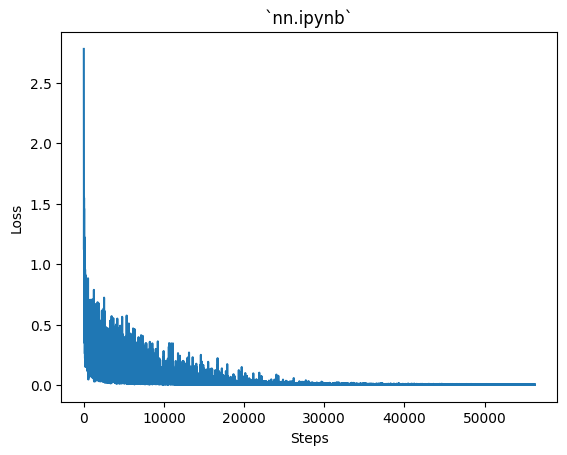

In [16]:
params, batchnorm_buffers, losses = train_loop(0.01, 30, [X_train, y_train], [X_val, y_val], val_interval=1) # clearly learns faster 
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("`batchnorm.ipynb.ipynb`")
plt.show()
# learning/overfitting faster but validation loss is better than in `nn.ipynb`
# maybe because of batchnorm_buffers: running mean and variance

* Step at which we get the best Val Loss:

  `Epoch: 9/30 | Loss: 0.0167 | Avg time per step: 0.79 ms | Validation Loss: 0.0899 |`

## Make Predictions

In [17]:
def predict(img_idx):
    img = torch.tensor(X_VAL[img_idx].tolist())[0] # (28, 28)
    y_true = y_val[img_idx].cpu()
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    y_pred = torch.argmax(forwardprop(img.reshape((1, -1)), y_true, params, batchnorm_buffers, training=False)[1], axis=-1).cpu()
    print(f"True Digit: {y_true}")
    print(f"Predicted Digit: {y_pred}")
    plt.show()

True Digit: tensor([1])
Predicted Digit: tensor([1])


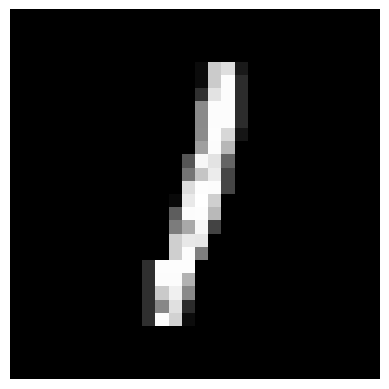

True Digit: tensor([5])
Predicted Digit: tensor([5])


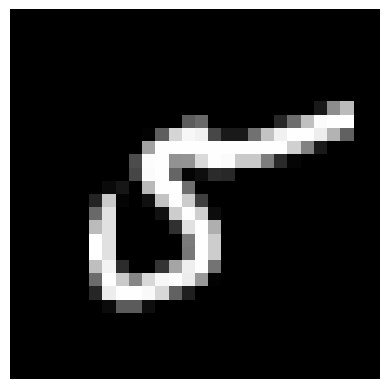

True Digit: tensor([6])
Predicted Digit: tensor([6])


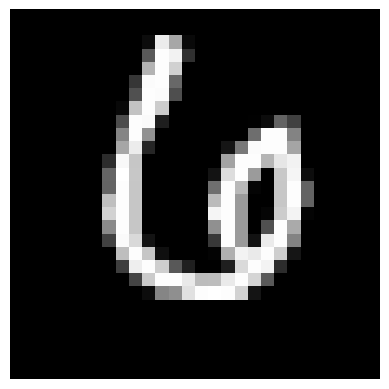

True Digit: tensor([4])
Predicted Digit: tensor([4])


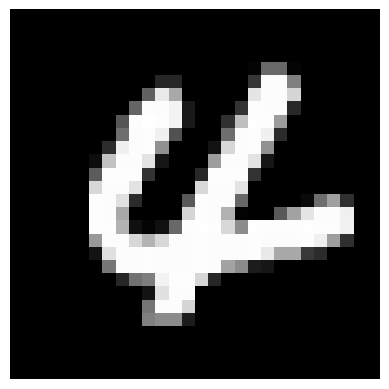

True Digit: tensor([0])
Predicted Digit: tensor([0])


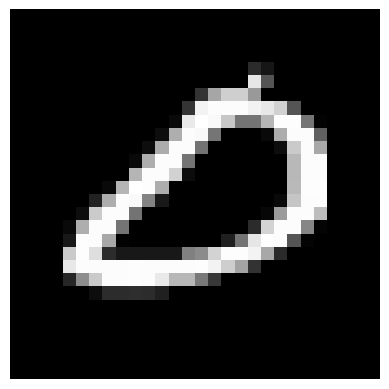

True Digit: tensor([1])
Predicted Digit: tensor([1])


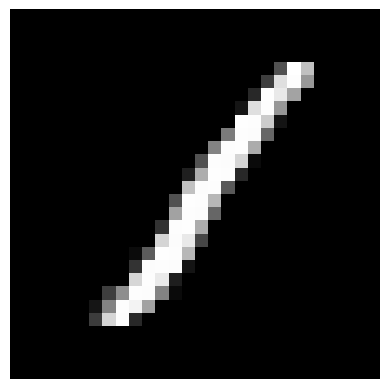

True Digit: tensor([7])
Predicted Digit: tensor([7])


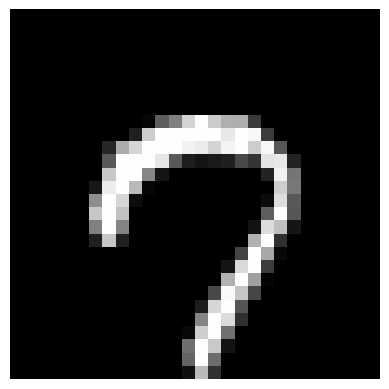

True Digit: tensor([3])
Predicted Digit: tensor([3])


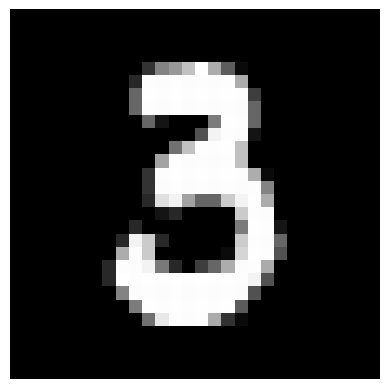

True Digit: tensor([9])
Predicted Digit: tensor([7])


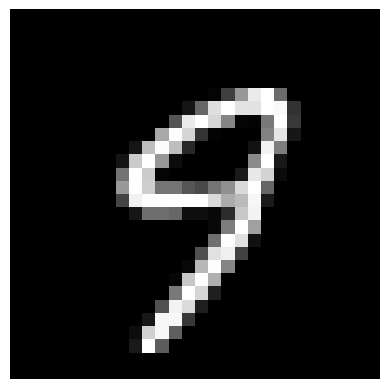

True Digit: tensor([2])
Predicted Digit: tensor([2])


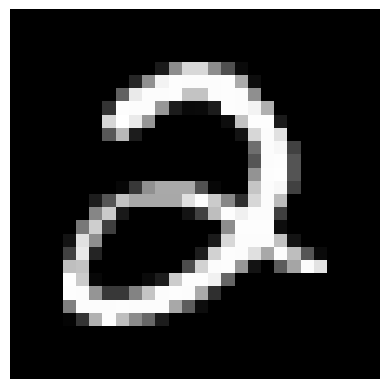

True Digit: tensor([3])
Predicted Digit: tensor([7])


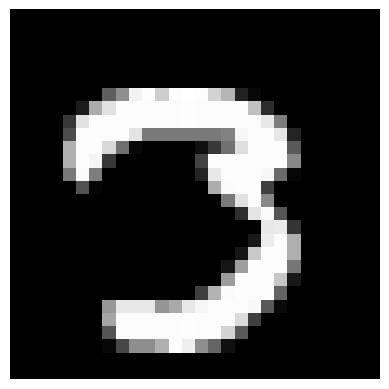

True Digit: tensor([7])
Predicted Digit: tensor([7])


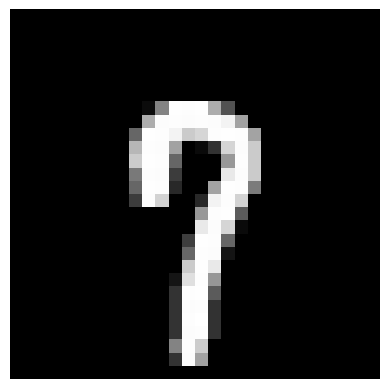

True Digit: tensor([6])
Predicted Digit: tensor([6])


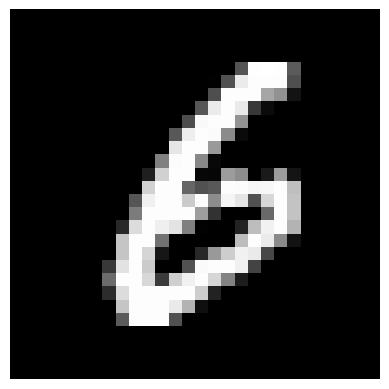

True Digit: tensor([6])
Predicted Digit: tensor([6])


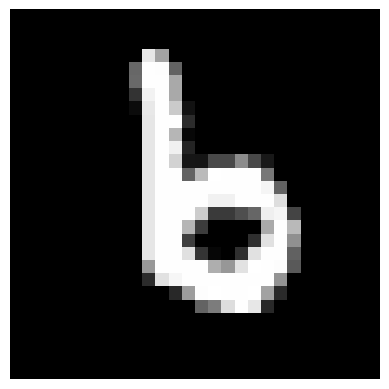

True Digit: tensor([8])
Predicted Digit: tensor([6])


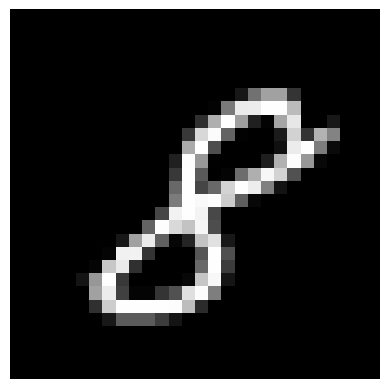

True Digit: tensor([0])
Predicted Digit: tensor([5])


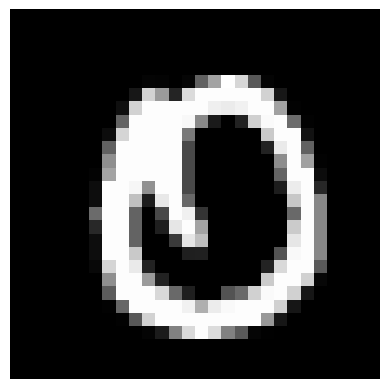

True Digit: tensor([5])
Predicted Digit: tensor([5])


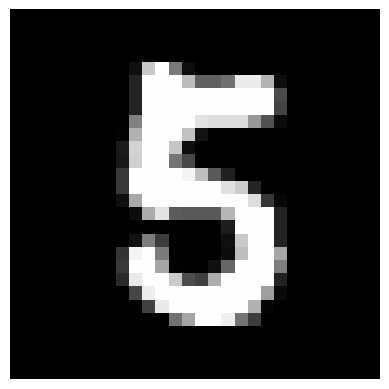

True Digit: tensor([2])
Predicted Digit: tensor([2])


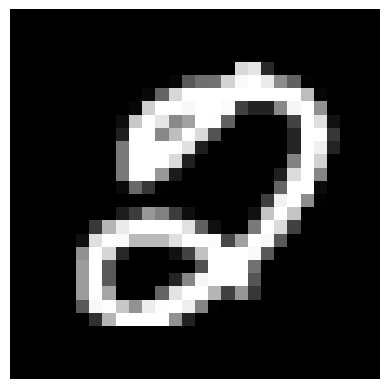

True Digit: tensor([4])
Predicted Digit: tensor([4])


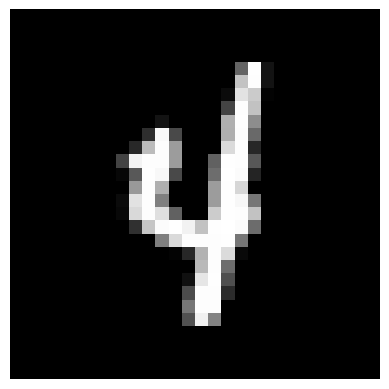

True Digit: tensor([7])
Predicted Digit: tensor([7])


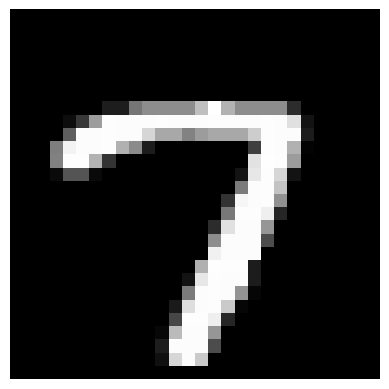

True Digit: tensor([4])
Predicted Digit: tensor([4])


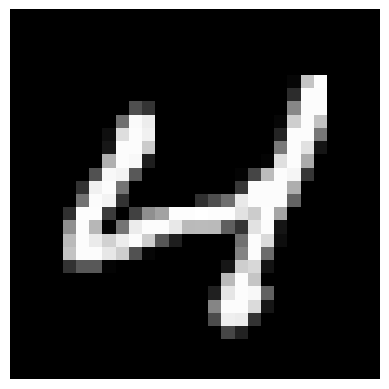

True Digit: tensor([4])
Predicted Digit: tensor([7])


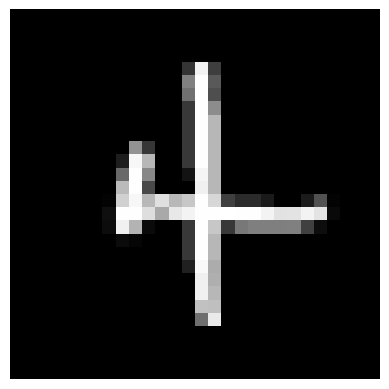

True Digit: tensor([4])
Predicted Digit: tensor([4])


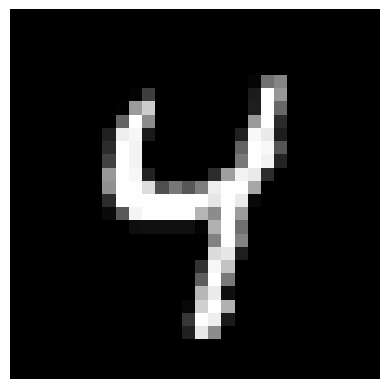

True Digit: tensor([4])
Predicted Digit: tensor([4])


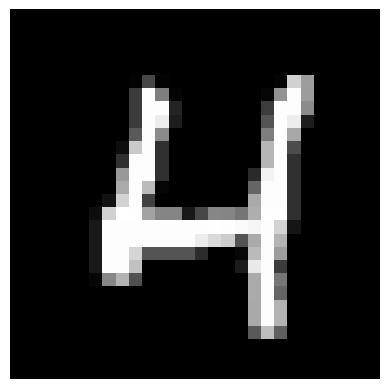

True Digit: tensor([9])
Predicted Digit: tensor([9])


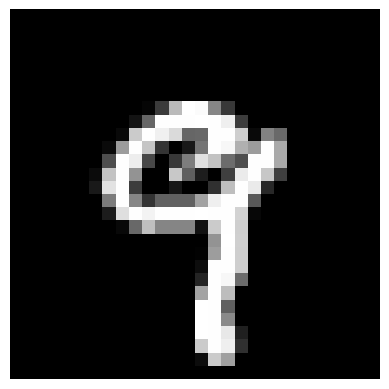

True Digit: tensor([1])
Predicted Digit: tensor([1])


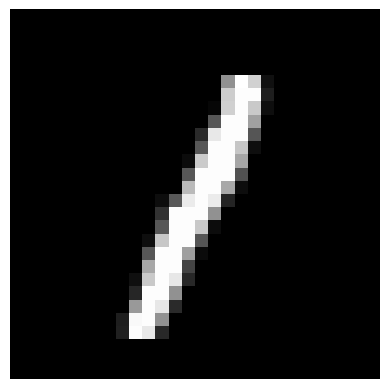

True Digit: tensor([0])
Predicted Digit: tensor([0])


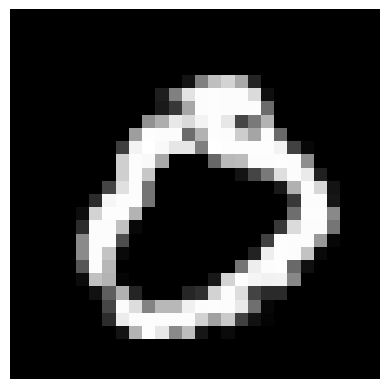

True Digit: tensor([6])
Predicted Digit: tensor([6])


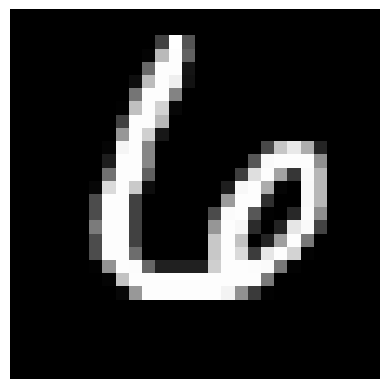

True Digit: tensor([9])
Predicted Digit: tensor([7])


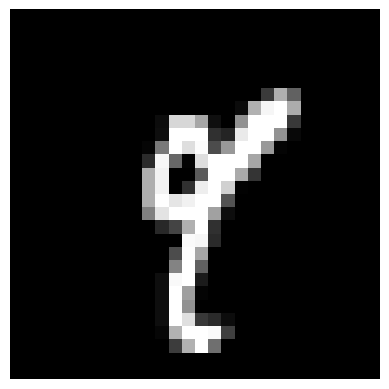

True Digit: tensor([5])
Predicted Digit: tensor([5])


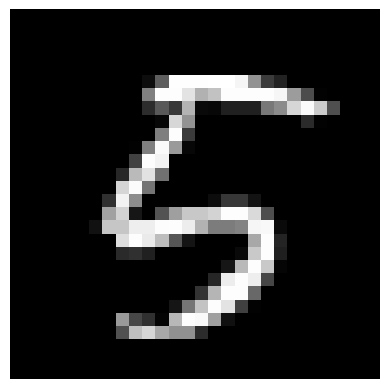

True Digit: tensor([8])
Predicted Digit: tensor([8])


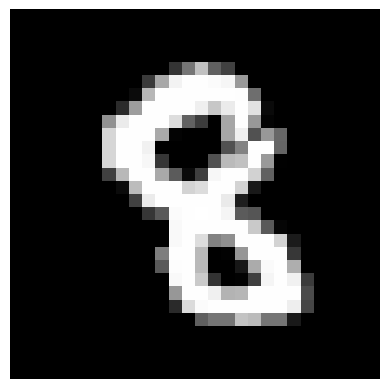

True Digit: tensor([9])
Predicted Digit: tensor([6])


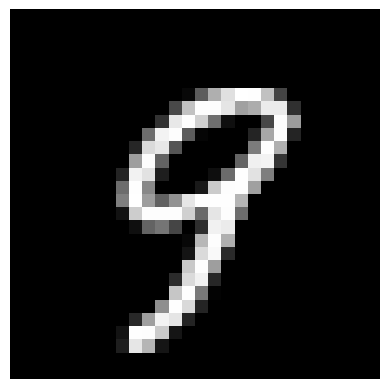

True Digit: tensor([7])
Predicted Digit: tensor([7])


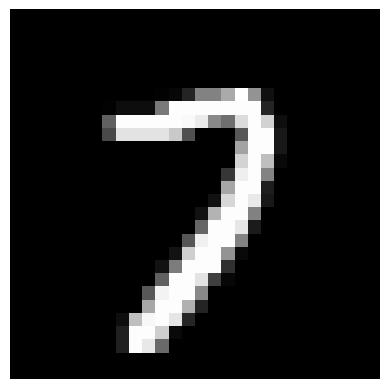

True Digit: tensor([9])
Predicted Digit: tensor([7])


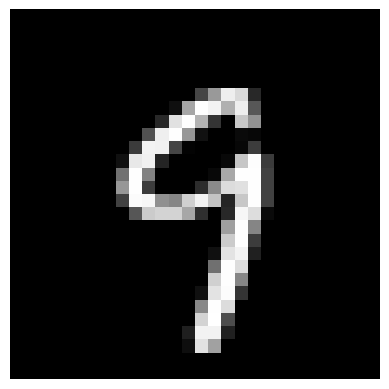

True Digit: tensor([2])
Predicted Digit: tensor([2])


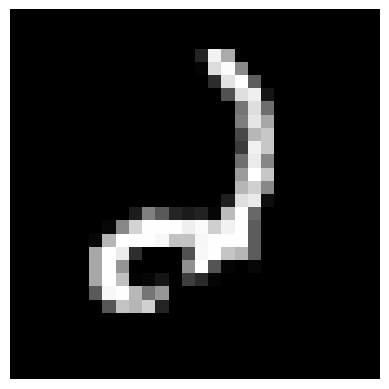

True Digit: tensor([9])
Predicted Digit: tensor([9])


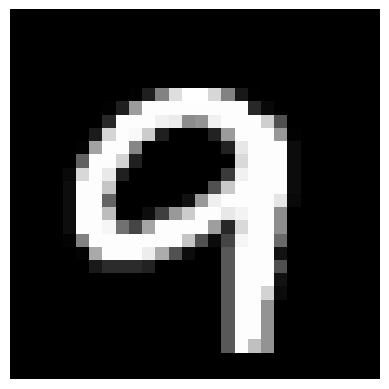

True Digit: tensor([1])
Predicted Digit: tensor([1])


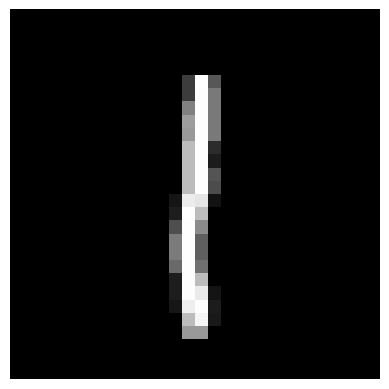

True Digit: tensor([5])
Predicted Digit: tensor([5])


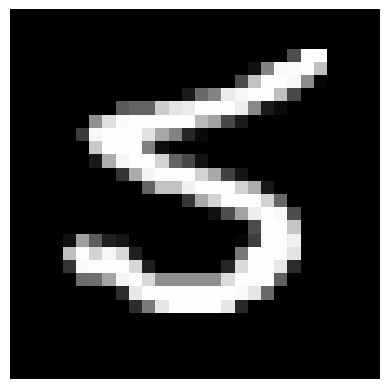

True Digit: tensor([4])
Predicted Digit: tensor([4])


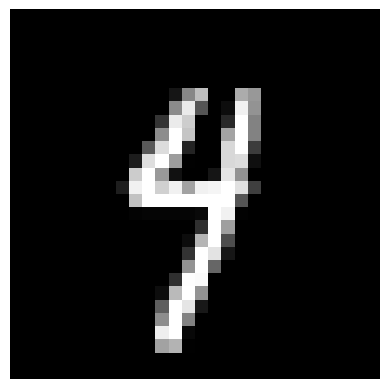

True Digit: tensor([8])
Predicted Digit: tensor([6])


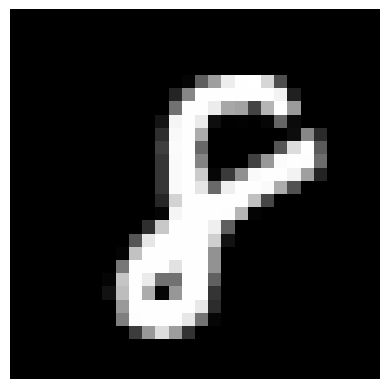

True Digit: tensor([5])
Predicted Digit: tensor([5])


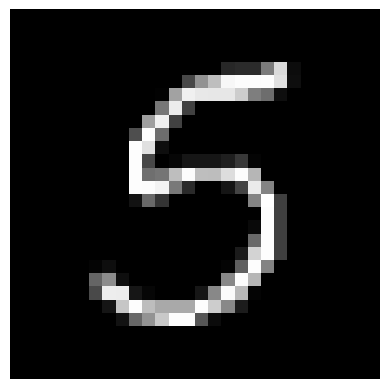

True Digit: tensor([1])
Predicted Digit: tensor([1])


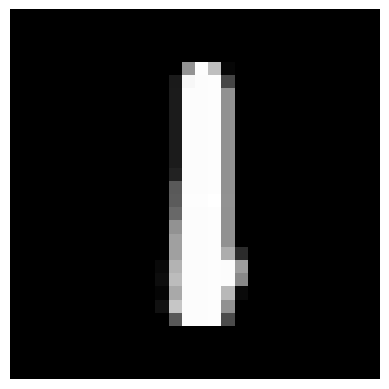

True Digit: tensor([5])
Predicted Digit: tensor([5])


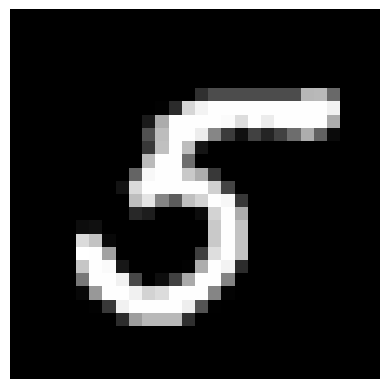

True Digit: tensor([4])
Predicted Digit: tensor([4])


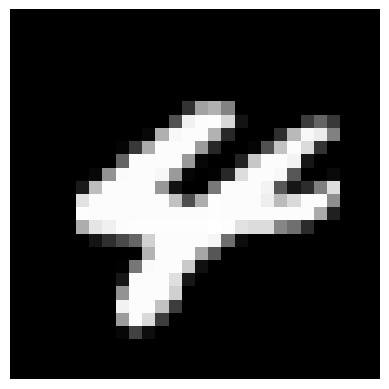

True Digit: tensor([3])
Predicted Digit: tensor([3])


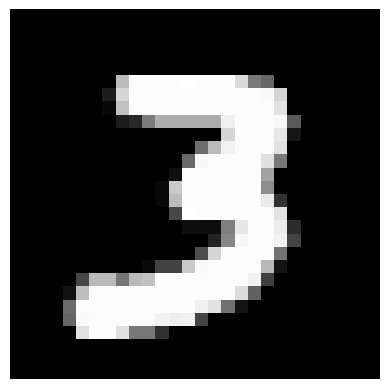

True Digit: tensor([4])
Predicted Digit: tensor([4])


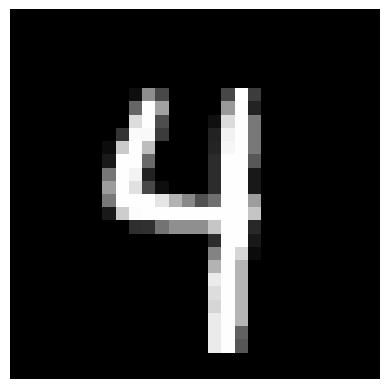

True Digit: tensor([2])
Predicted Digit: tensor([2])


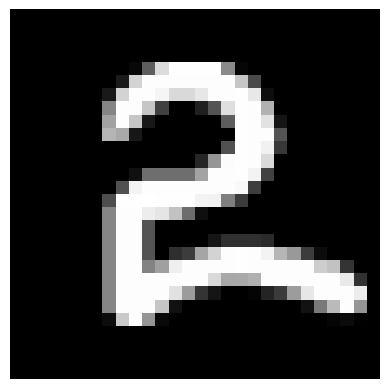

True Digit: tensor([1])
Predicted Digit: tensor([1])


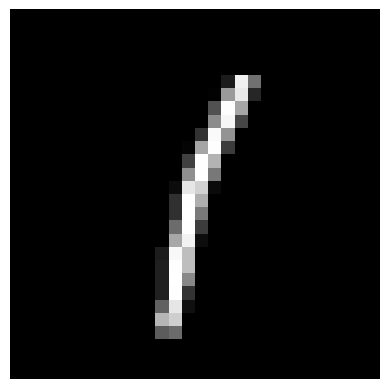

True Digit: tensor([4])
Predicted Digit: tensor([4])


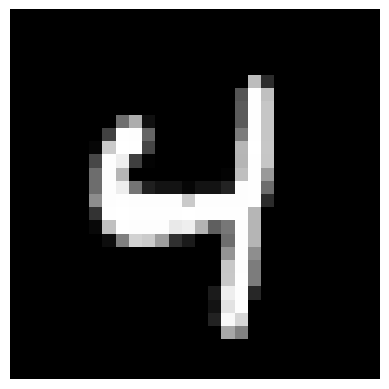

True Digit: tensor([0])
Predicted Digit: tensor([0])


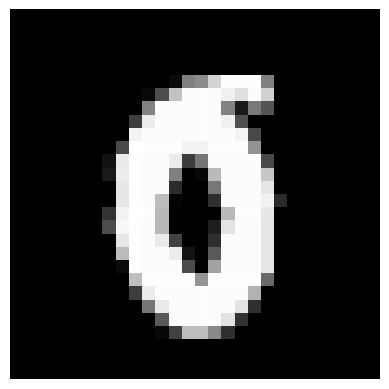

True Digit: tensor([2])
Predicted Digit: tensor([2])


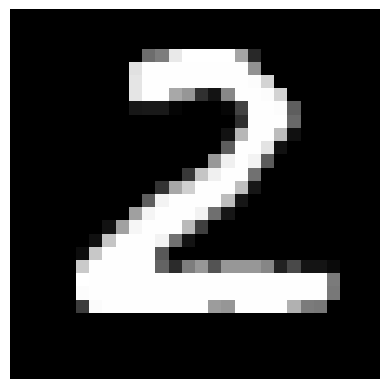

True Digit: tensor([4])
Predicted Digit: tensor([7])


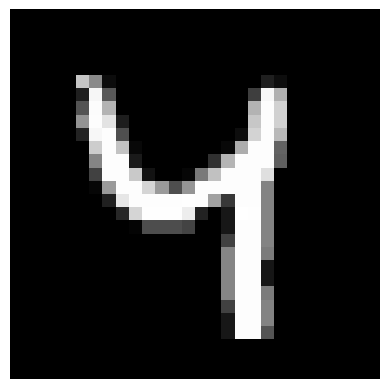

True Digit: tensor([1])
Predicted Digit: tensor([1])


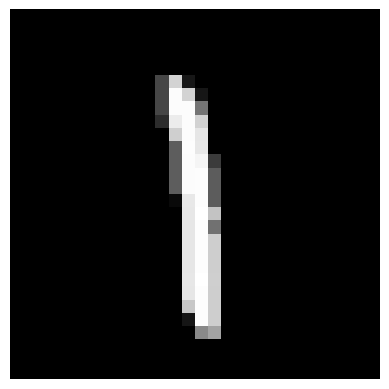

True Digit: tensor([0])
Predicted Digit: tensor([0])


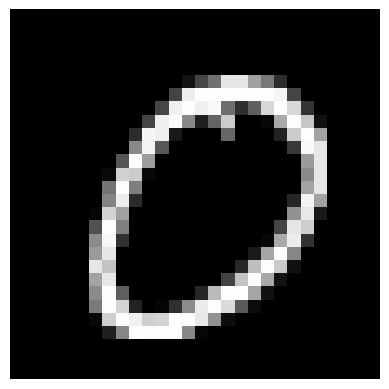

True Digit: tensor([4])
Predicted Digit: tensor([4])


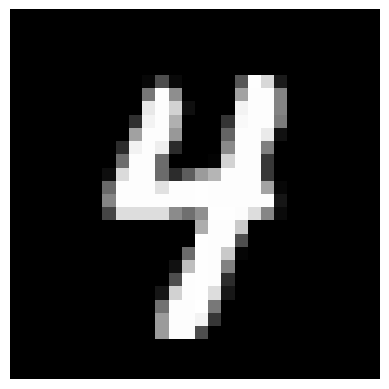

True Digit: tensor([2])
Predicted Digit: tensor([2])


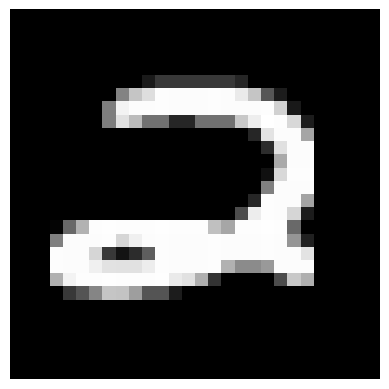

True Digit: tensor([0])
Predicted Digit: tensor([0])


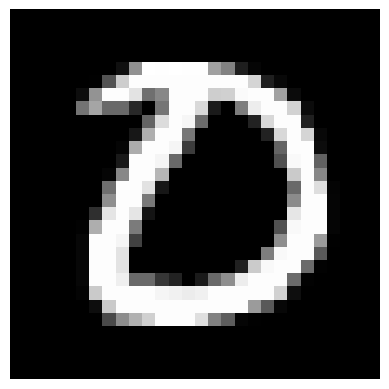

True Digit: tensor([7])
Predicted Digit: tensor([7])


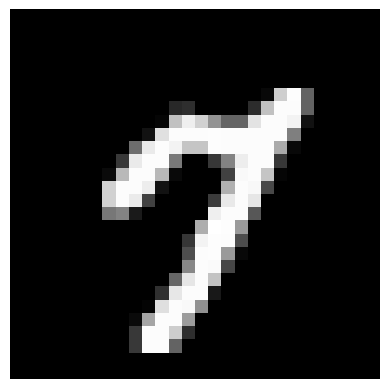

True Digit: tensor([5])
Predicted Digit: tensor([5])


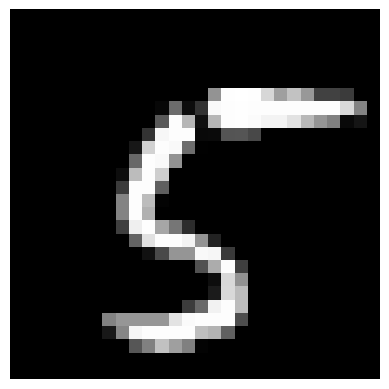

True Digit: tensor([6])
Predicted Digit: tensor([6])


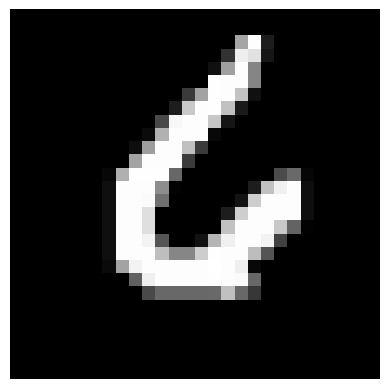

True Digit: tensor([9])
Predicted Digit: tensor([7])


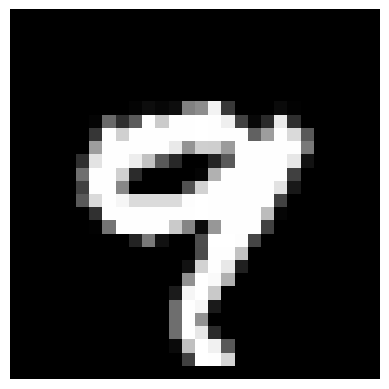

True Digit: tensor([3])
Predicted Digit: tensor([3])


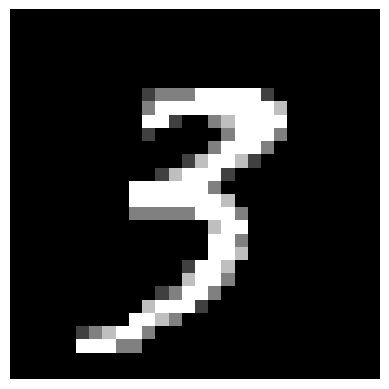

True Digit: tensor([5])
Predicted Digit: tensor([5])


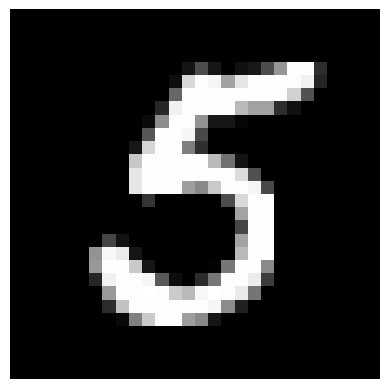

True Digit: tensor([6])
Predicted Digit: tensor([7])


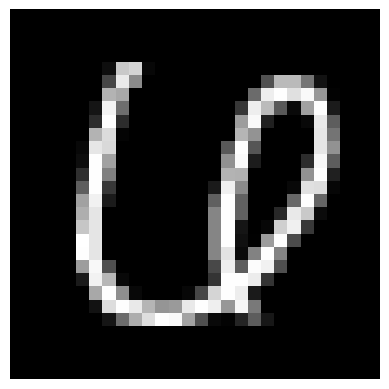

True Digit: tensor([1])
Predicted Digit: tensor([1])


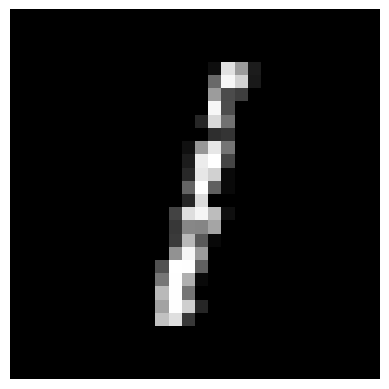

True Digit: tensor([2])
Predicted Digit: tensor([7])


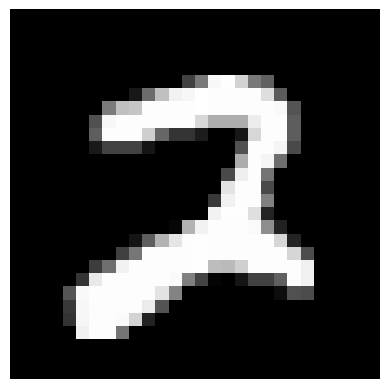

True Digit: tensor([3])
Predicted Digit: tensor([3])


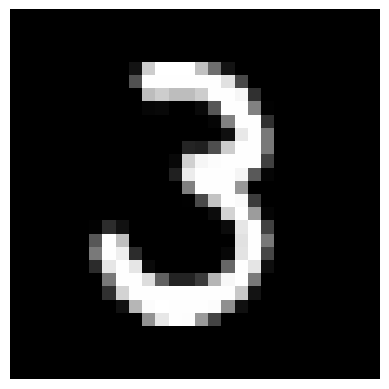

True Digit: tensor([3])
Predicted Digit: tensor([5])


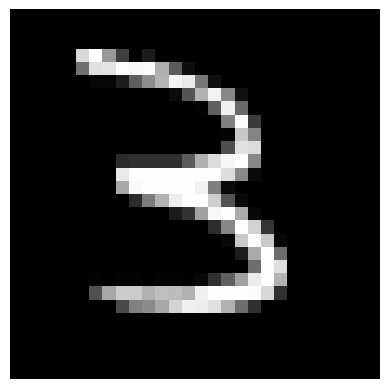

True Digit: tensor([1])
Predicted Digit: tensor([1])


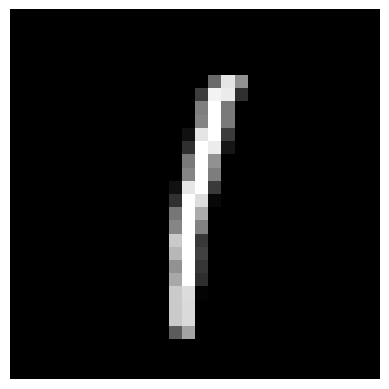

True Digit: tensor([9])
Predicted Digit: tensor([7])


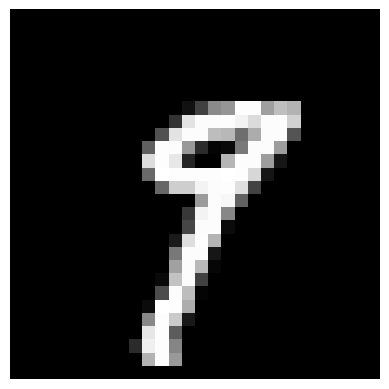

True Digit: tensor([7])
Predicted Digit: tensor([7])


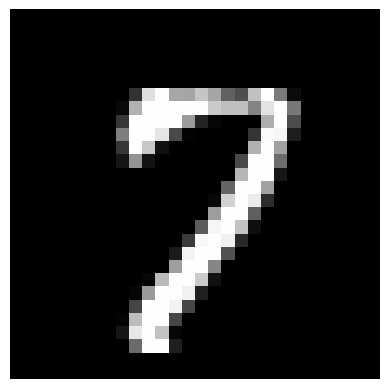

True Digit: tensor([9])
Predicted Digit: tensor([7])


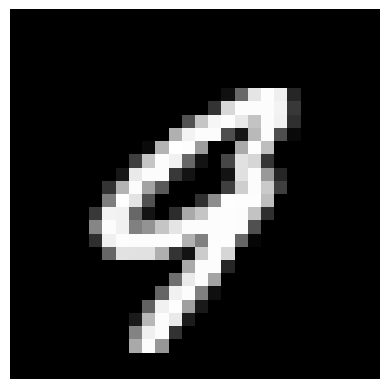

True Digit: tensor([8])
Predicted Digit: tensor([6])


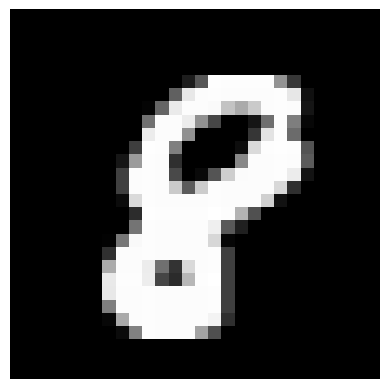

True Digit: tensor([8])
Predicted Digit: tensor([7])


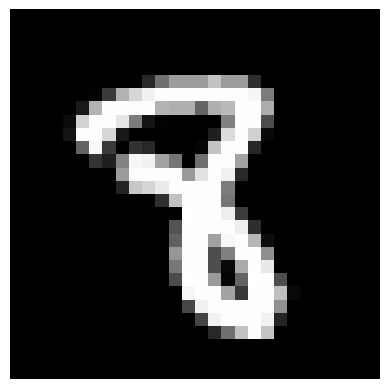

True Digit: tensor([3])
Predicted Digit: tensor([3])


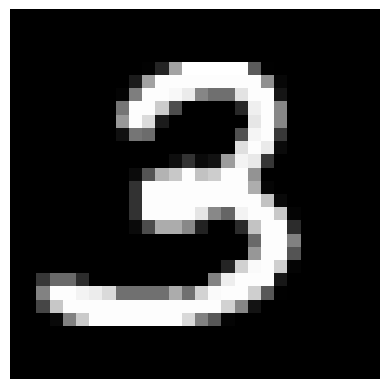

True Digit: tensor([5])
Predicted Digit: tensor([5])


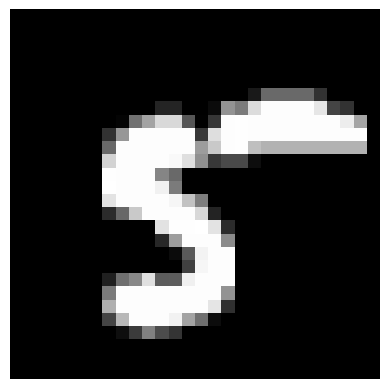

True Digit: tensor([2])
Predicted Digit: tensor([2])


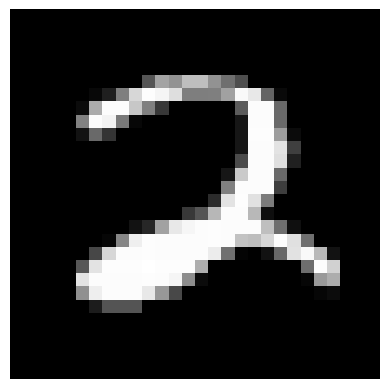

True Digit: tensor([9])
Predicted Digit: tensor([9])


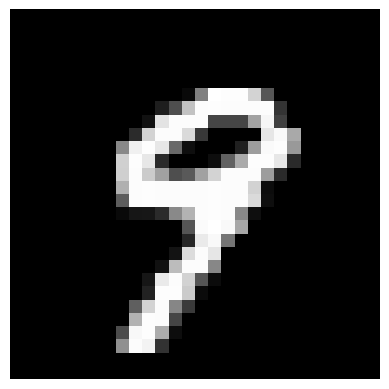

True Digit: tensor([3])
Predicted Digit: tensor([3])


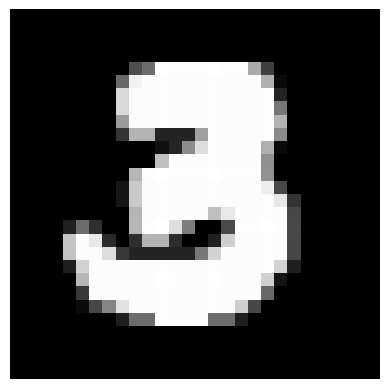

True Digit: tensor([2])
Predicted Digit: tensor([2])


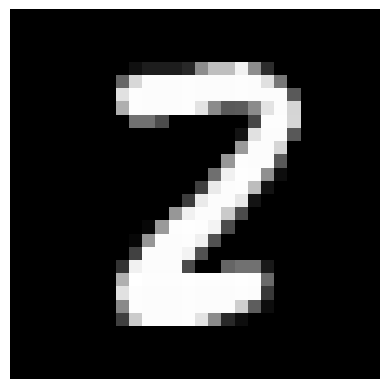

True Digit: tensor([1])
Predicted Digit: tensor([1])


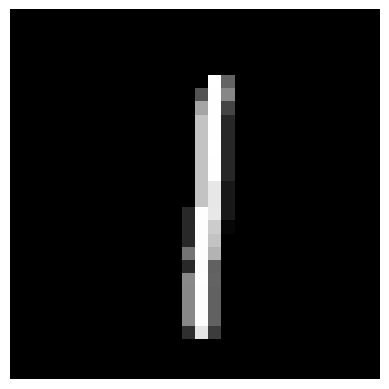

True Digit: tensor([3])
Predicted Digit: tensor([5])


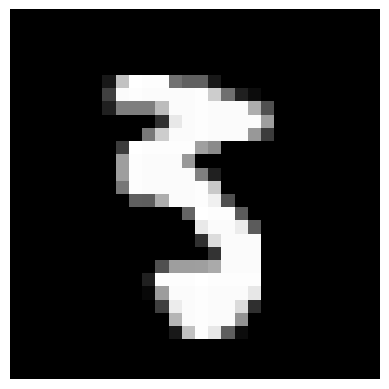

True Digit: tensor([2])
Predicted Digit: tensor([2])


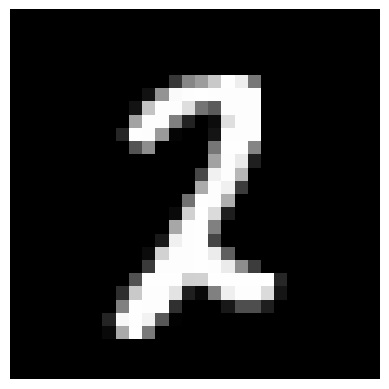

True Digit: tensor([3])
Predicted Digit: tensor([3])


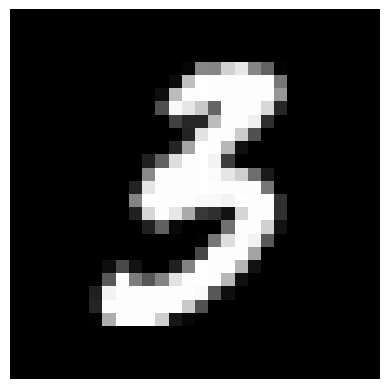

True Digit: tensor([1])
Predicted Digit: tensor([1])


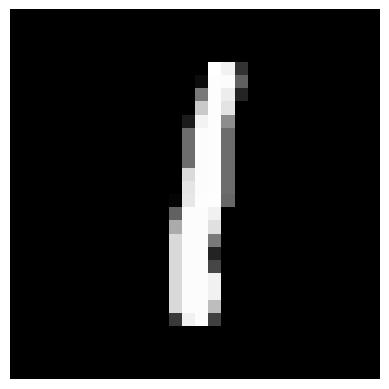

True Digit: tensor([1])
Predicted Digit: tensor([1])


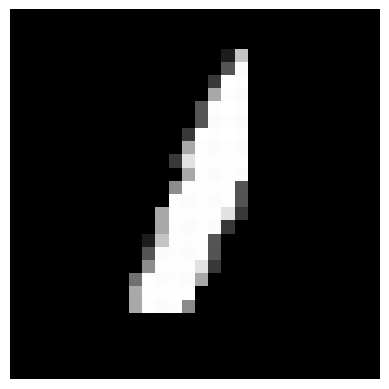

True Digit: tensor([8])
Predicted Digit: tensor([5])


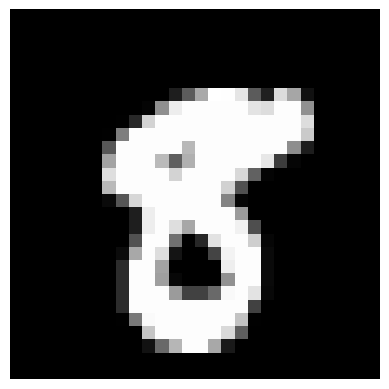

True Digit: tensor([2])
Predicted Digit: tensor([2])


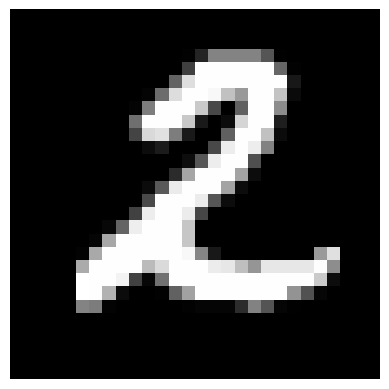

True Digit: tensor([5])
Predicted Digit: tensor([5])


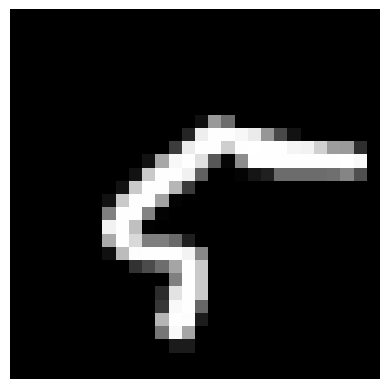

True Digit: tensor([0])
Predicted Digit: tensor([0])


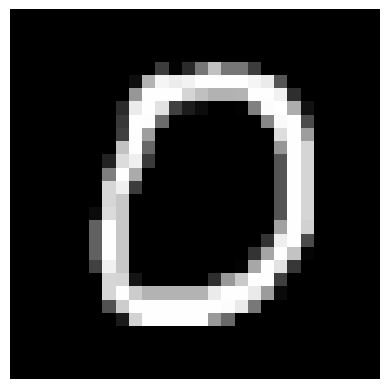

True Digit: tensor([1])
Predicted Digit: tensor([1])


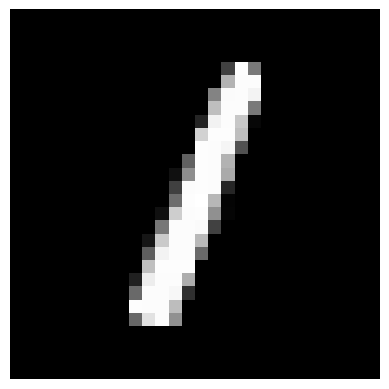

True Digit: tensor([9])
Predicted Digit: tensor([9])


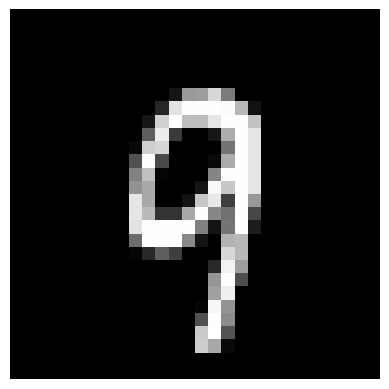

True Digit: tensor([5])
Predicted Digit: tensor([5])


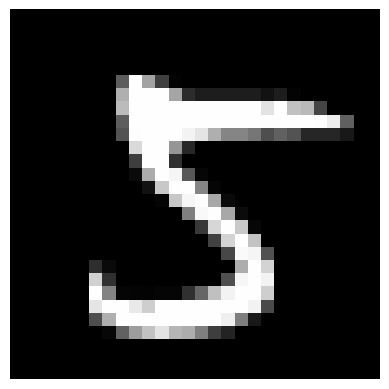

True Digit: tensor([2])
Predicted Digit: tensor([2])


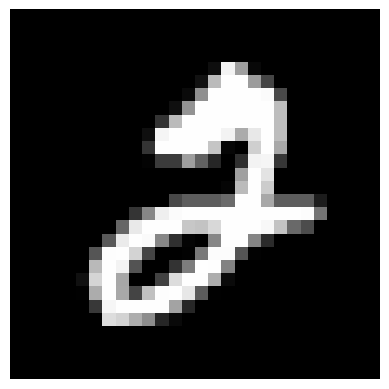

True Digit: tensor([6])
Predicted Digit: tensor([6])


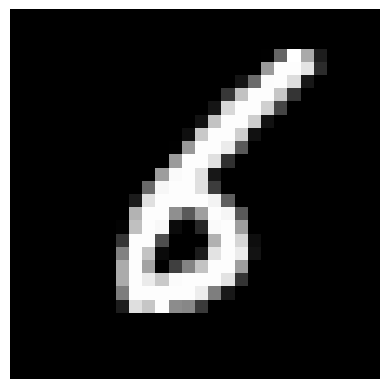

True Digit: tensor([3])
Predicted Digit: tensor([3])


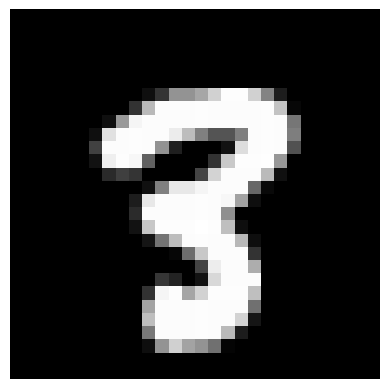

True Digit: tensor([3])
Predicted Digit: tensor([3])


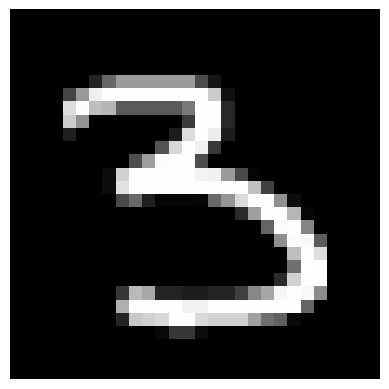

True Digit: tensor([3])
Predicted Digit: tensor([3])


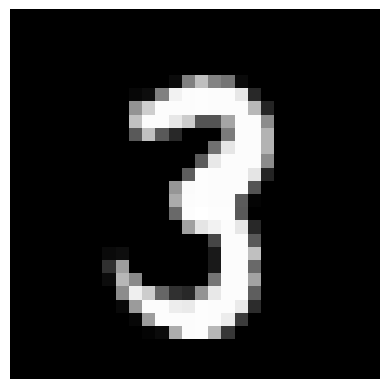

True Digit: tensor([2])
Predicted Digit: tensor([2])


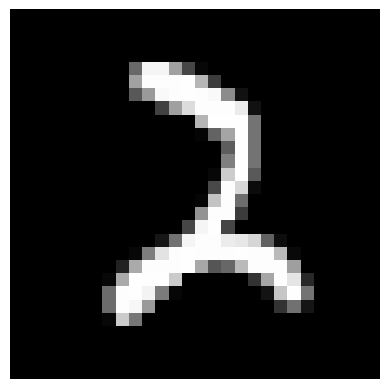

True Digit: tensor([5])
Predicted Digit: tensor([5])


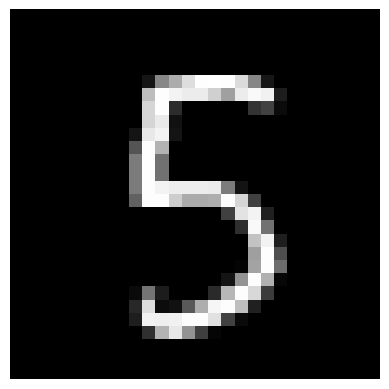

In [18]:
for _ in range(100):
    predict(torch.randint(10_000, (1,)))